In [1]:
from utilities import *

import numpy as np
import pandas as pd
import diplib as dip
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

PyDIPjavaio unavailable:
libjvm.so: cannot open shared object file: No such file or directory

libjvm not found
DIPlib -- a quantitative image analysis library
Version 3.2.0 (Feb  8 2022)
For more information see https://diplib.org


In [2]:
parent_dir = "transformed/"
embryos_orig, _ = load_dip_images(parent_dir+'orig_resize/')
embryos_orig_rel, _ = load_dip_images(parent_dir+'orig_rel/')
embryos_transf, _ = load_dip_images(parent_dir+'embr_masks/')
# embryos_gray, dip_names = load_dip_images(parent_dir+'crop_embr_gray/')
blue_gray, _ = load_dip_images(parent_dir+'blue_resize/')
blue_thresh, _ = load_dip_images(parent_dir+'blue_thresh/')
blue_transf, _ = load_dip_images(parent_dir+'blue_transf/')
blue_rel_orig, _ = load_dip_images(parent_dir+'blue_rel_orig/')

In [3]:
# measurements on embryos and blue areas
features = ['Perimeter', 'Size',
            'Circularity', 'Roundness',
            'StandardDeviation']
labeled_images, measurements_embr = measure_elements(embryos_transf, embryos_orig, features=features)
areas, perimeters, circularity, roundness, stand_dev = measurements_array(measurements_embr, features)
labeled_images_blue, measurements_blue = measure_elements(blue_thresh, blue_gray, features=features)
areas_blue, perimeters_blue, circularity_blue, roundness_blue, stand_dev_blue = measurements_array(measurements_blue, features)

tot_area_blue = []
tot_perim_blue = []
tot_std_blue = []
tot_round_blue = []
for i in range(len(areas_blue)):
    tot_area_blue.append(np.sum(areas_blue[i]))
    tot_perim_blue.append(np.sum(perimeters_blue[i]))
    tot_std_blue.append(np.sum(stand_dev_blue[i]))
    tot_round_blue.append(np.sum(roundness_blue[i]))

blue_rel_area = np.divide(tot_area_blue,areas)
blue_rel_perim = np.divide(tot_perim_blue,perimeters)
perc_area_blues = blue_rel_area*100
perc_perim_blues = blue_rel_perim*100


In [4]:
d = {'area': areas, 'perimeter': perimeters,
                'area blue': tot_area_blue, 'perimeter blue': tot_perim_blue,
                'percentage area blue': perc_area_blues, 'percentage perim blue': perc_perim_blues, 
                } # 'relative blue area': blue_rel_area, 'relative perim area': blue_rel_perim,
df = pd.DataFrame(data=d) #  'roundness':roundness, 'circularity':circularity,  'round blue': tot_round_blue

In [5]:
df = np.round(df,2)
df.head(15)

,area,perimeter,area blue,perimeter blue,percentage area blue,percentage perim blue
0,14687.0,854.54,3231.0,274.01,22.00,32.07
1,16872.0,758.26,5604.0,325.70,33.21,42.95
2,12535.0,733.43,1106.0,129.05,8.82,17.60
3,24177.0,947.80,10123.0,424.44,41.87,44.78
4,13535.0,666.25,558.0,91.79,4.12,13.78
5,13297.0,798.93,2576.0,191.56,19.37,23.98
6,15743.0,634.55,4298.0,378.41,27.30,59.63
7,10004.0,639.69,1200.0,124.40,12.00,19.45
8,15044.0,694.43,3333.0,226.40,22.16,32.60
9,16100.0,792.40,3946.0,317.20,24.51,40.03


<h4>Clustering to determine classes</h4>

In [6]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
df['class_kmeans'] = kmeans.labels_

In [7]:
kmeans.labels_

array([1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 2,
       1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2], dtype=int32)

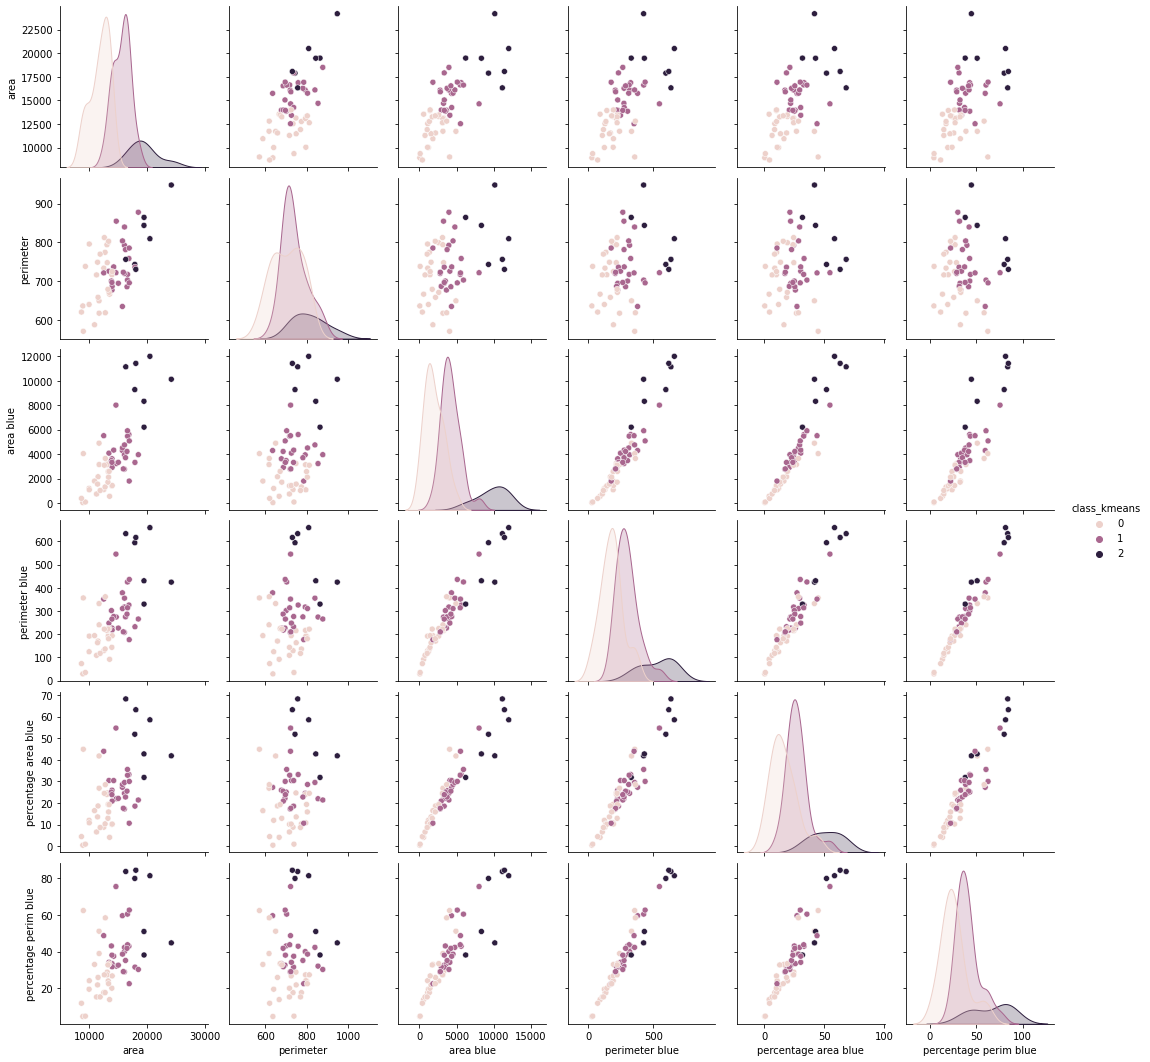

In [8]:
sns.pairplot(df,hue="class_kmeans")

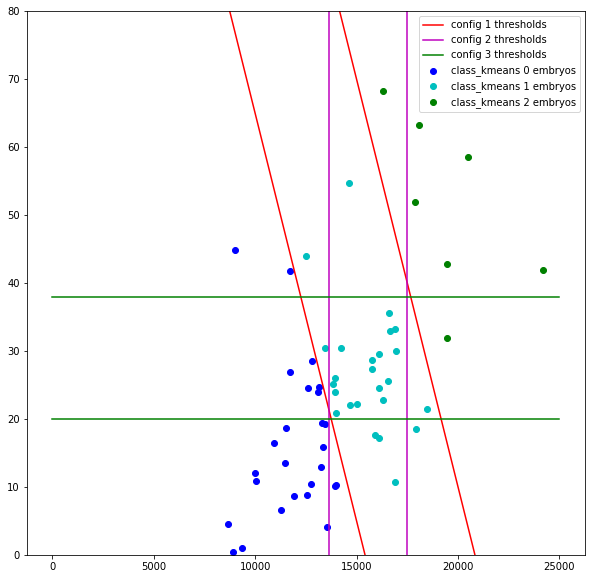

In [9]:
plt.figure(figsize=(10,10))
x_rg = np.arange(2)



x_1 = np.linspace(0,25000, 200000)
y_1 = 185- 240*x_1/20000
plt.plot(x_1,y_1, label="config 1 thresholds", color='r')

x_2 = np.linspace(0,25000, 200000)
y_2 = 250 - 240*x_2/20000
plt.plot(x_2,y_2,color='r')



x_3 = np.full(shape=(100), fill_value=13650)
y_3 = np.linspace(0,80,100)
plt.plot(x_3,y_3, label="config 2 thresholds", color='m')

x_3 = np.full(shape=(100), fill_value=17500)
y_3 = np.linspace(0,80,100)
plt.plot(x_3,y_3, color='m')

# threshold 3
y_3 = np.full(shape=(1000), fill_value=20)
x_3 = np.linspace(0,25000,1000)
plt.plot(x_3,y_3, label="config 3 thresholds", color='g')
y_3 = np.full(shape=(1000), fill_value=38)
x_3 = np.linspace(0,25000,1000)
plt.plot(x_3,y_3, color='g')

colors = ['b', 'c', 'g']
for i in range(3):
    plt.scatter(x=df[df['class_kmeans'] == i]['area'], 
                y=df[df['class_kmeans'] == i]['percentage area blue'], 
                c=colors[i], label=f"class_kmeans {i} embryos")
plt.ylim([0,80])
plt.legend()
plt.show()

In [10]:
# create second classes
x = lambda val: 0 if val < 13650 else 1 if val >= 13650 and val < 17500 else 2

df['thresh_class']= df['area']
df['thresh_class'] = df['thresh_class'].apply(x) 

# create third classes
x_2 = lambda val: 0 if val < 20 else 1 if val >= 20 and val < 38 else 2

df['thresh_class_2']= df['percentage area blue']
df['thresh_class_2'] = df['thresh_class_2'].apply(x_2) 

df.head(3)

,area,perimeter,area blue,perimeter blue,percentage area blue,percentage perim blue,class_kmeans,thresh_class,thresh_class_2
0,14687.0,854.54,3231.0,274.01,22.00,32.07,1,1,1
1,16872.0,758.26,5604.0,325.70,33.21,42.95,1,1,1
2,12535.0,733.43,1106.0,129.05,8.82,17.60,0,0,0


In [11]:
# create dataset
X = df.drop(columns=['class_kmeans', 'thresh_class', 'thresh_class_2'])
y = df[['class_kmeans', 'thresh_class', 'thresh_class_2']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)
print("KMeans classes")
# define and fit kmeans model
clf_kmeans = svm.SVC()
clf_kmeans.fit(X_train,y_train['class_kmeans'])
# make predictions
pred_kmeans =clf_kmeans.predict(X_test)
print(classification_report(y_test['class_kmeans'], pred_kmeans, zero_division=0))

print("Threshold based on area")
# define and fit thresh model
clf_thresh = svm.SVC()
clf_thresh.fit(X_train,y_train['thresh_class'])
# make predictions
pred_thresh =clf_thresh.predict(X_test)
print(classification_report(y_test['thresh_class'], pred_thresh, zero_division=0))

print("Threshold based on blue area %")
# define and fit thresh model 2
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class_2'])
# make predictions
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class_2'], pred, zero_division=0))
#predict_on_train
pred_train = clf.predict(X_train)
predictions = np.hstack((pred,pred_train))


KMeans classes
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         1

    accuracy                           0.92        12
   macro avg       0.92      0.96      0.93        12
weighted avg       0.94      0.92      0.92        12

Threshold based on area
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.25      1.00      0.40         1
           2       1.00      1.00      1.00         1

    accuracy                           0.75        12
   macro avg       0.75      0.90      0.74        12
weighted avg       0.94      0.75      0.80        12

Threshold based on blue area %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.60      1.00      0.75         3
     

[0 1 2]
(58,) (58, 2)


/tmp/ipykernel_34717/4257215442.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['preds'] = predictions


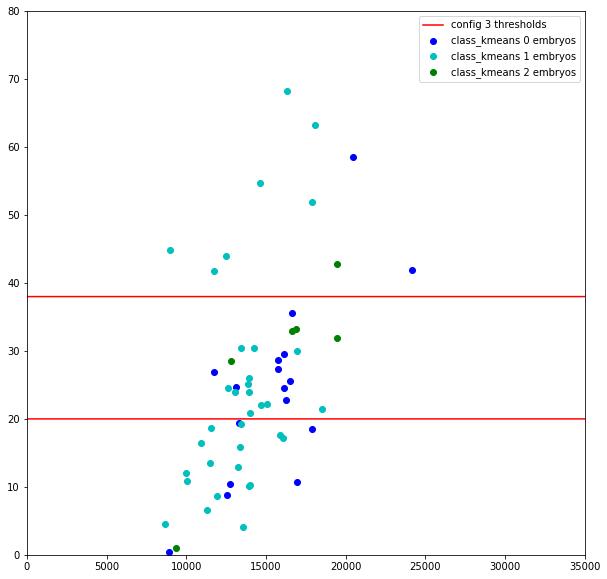

In [12]:
plt.figure(figsize=(10,10))
x_rg = np.arange(2)

# threshold 3
y_3 = np.full(shape=(10000), fill_value=20)
x_3 = np.linspace(0,35000,10000)
plt.plot(x_3,y_3, label="config 3 thresholds", color='r')
y_3 = np.full(shape=(10000), fill_value=38)
x_3 = np.linspace(0,35000,10000)
plt.plot(x_3,y_3, color='r')

colors = ['b', 'c', 'g']

plot_df = df[['area','percentage area blue']]
print(np.unique(predictions))
print(predictions.shape, plot_df.shape)
plot_df['preds'] = predictions
for i in range(3):
    plt.scatter(x=plot_df[plot_df['preds'] == i]['area'], 
                y=plot_df[plot_df['preds'] == i]['percentage area blue'], 
                c=colors[i], label=f"class_kmeans {i} embryos")
plt.ylim([0,80])
plt.legend()
plt.margins(x=0,y=0)
plt.show()

<h4>
HOG
</h4>

<h4>
Create HOG images and features
</h4>

In [13]:
measures = ['Size']
labeled_embr, measurements = measure_elements(embryos_transf, embryos_orig, measures)
meas_np = parse_features(measurements)
new_images = []
for i in range(len(labeled_embr)):
    curr_areas = meas_np[i]
    if len(curr_areas) > 1:
        max_area = curr_areas.max()
        new_img = dip.SmallObjectsRemove(embryos_transf[i], int(max_area-1))
        new_images.append(new_img)
    else: 
        new_images.append(embryos_transf[i])

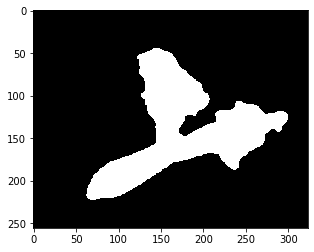

In [14]:
new_images[0].Show()

In [15]:
hog_images_thresh, hog_feat_thresh=  [], []
for i in range(len(embryos_transf)):
    feat, img = hog(new_images[i], visualize=True)
    hog_images_thresh.append(img)
    hog_feat_thresh.append(feat)

(92340,) (92340,)


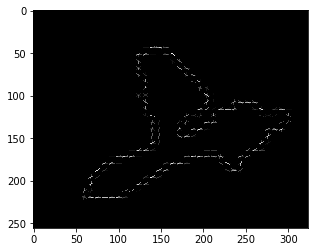

In [16]:
print(hog_feat_thresh[0].shape, hog_feat_thresh[1].shape)
dip.Image(hog_images_thresh[0]).Show()

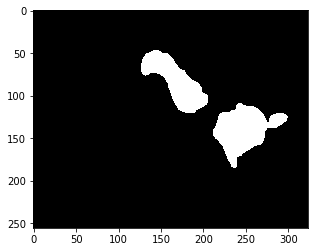

In [17]:
blue_transf[0].Show()

In [18]:
# hog on blue part
blue_hog = blue_transf
hog_images_blue, hog_feat_blue =  [], []
for i in range(len(blue_hog)):
    feat, img = hog(blue_hog[i], visualize=True)
    hog_images_blue.append(img)
    hog_feat_blue.append(feat)

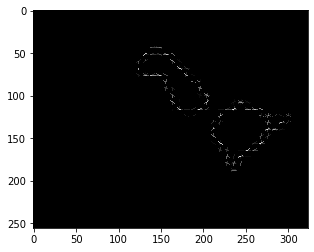

In [19]:
dip.Image(hog_images_blue[0]).Show()

<h4>Hog SVM on full embryo<h4/>

In [20]:
# create data
thresh_feat = np.vstack(hog_feat_thresh)
X = thresh_feat
y = df[['class_kmeans', 'thresh_class','thresh_class_2']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
    
# define and train kmeans svc
clf = svm.SVC()
clf.fit(X_train,y_train['class_kmeans'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['class_kmeans'], pred, zero_division=0))
# define and train thresh svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class'], pred, zero_division=0))
# define and train thresh 2 svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class_2'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class_2'], pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.25      1.00      0.40         3
           2       0.00      0.00      0.00         1

    accuracy                           0.25        12
   macro avg       0.08      0.33      0.13        12
weighted avg       0.06      0.25      0.10        12

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.08      1.00      0.15         1
           2       0.00      0.00      0.00         1

    accuracy                           0.08        12
   macro avg       0.03      0.33      0.05        12
weighted avg       0.01      0.08      0.01        12

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.25      1.00      0.40         3
           2       0.00      0.00      0.00         3

    accuracy        

<h4>Hog SVM on blue area</h4>

In [21]:
# create data
blue_feat = np.vstack(hog_feat_blue)
X = blue_feat
y = df[['class_kmeans', 'thresh_class','thresh_class_2']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# define and train kmeans svc
clf = svm.SVC()
clf.fit(X_train,y_train['class_kmeans'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['class_kmeans'], pred, zero_division=0))

# define and train thresh 1 svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class'], pred, zero_division=0))

# define and train thresh 2 svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class_2'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class_2'], pred, zero_division=0))
#predict_on_train
pred_train = clf.predict(X_train)
predictions = np.hstack((pred,pred_train))



              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.50      1.00      0.67         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75        12
   macro avg       0.50      0.58      0.51        12
weighted avg       0.79      0.75      0.74        12

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.14      1.00      0.25         1
           2       0.00      0.00      0.00         1

    accuracy                           0.50        12
   macro avg       0.38      0.50      0.31        12
weighted avg       0.85      0.50      0.58        12

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.50      1.00      0.67         3
           2       0.00      0.00      0.00         3

    accuracy        

<h4>Hog SVM with combined embryo and blue features</h4>

[0 1 2]
(58,) (58, 2)


/tmp/ipykernel_34717/494834616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['preds'] = predictions


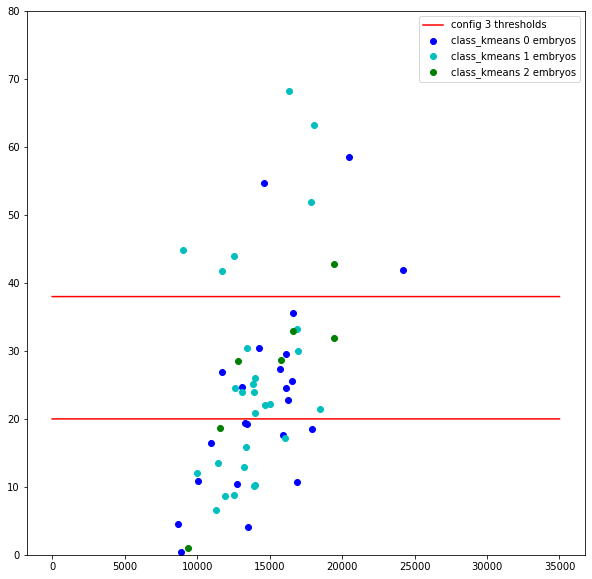

In [22]:
plt.figure(figsize=(10,10))
x_rg = np.arange(2)

# threshold 3
y_3 = np.full(shape=(10000), fill_value=20)
x_3 = np.linspace(0,35000,10000)
plt.plot(x_3,y_3, label="config 3 thresholds", color='r')
y_3 = np.full(shape=(10000), fill_value=38)
x_3 = np.linspace(0,35000,10000)
plt.plot(x_3,y_3, color='r')

colors = ['b', 'c', 'g']

plot_df = df[['area','percentage area blue']]
print(np.unique(predictions))
print(predictions.shape, plot_df.shape)
plot_df['preds'] = predictions
for i in range(3):
    plt.scatter(x=plot_df[plot_df['preds'] == i]['area'], 
                y=plot_df[plot_df['preds'] == i]['percentage area blue'], 
                c=colors[i], label=f"class_kmeans {i} embryos")
plt.ylim([0,80])
plt.legend()
plt.show()

In [23]:
tot_feats = np.hstack([thresh_feat, blue_feat])
tot_feats.shape


(58, 184680)

In [24]:
# create data
X = tot_feats
y = df[['class_kmeans', 'thresh_class','thresh_class_2']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# define and train kmeans svc
clf = svm.SVC()
clf.fit(X_train,y_train['class_kmeans'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['class_kmeans'], pred, zero_division=0))
# define and train thresh svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class'], pred, zero_division=0))
# define and train thresh 2 svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class_2'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class_2'], pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.27      1.00      0.43         3
           2       0.00      0.00      0.00         1

    accuracy                           0.33        12
   macro avg       0.42      0.38      0.22        12
weighted avg       0.73      0.33      0.26        12

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.08      1.00      0.15         1
           2       0.00      0.00      0.00         1

    accuracy                           0.08        12
   macro avg       0.03      0.33      0.05        12
weighted avg       0.01      0.08      0.01        12

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.25      1.00      0.40         3
           2       0.00      0.00      0.00         3

    accuracy        

<h4>Uniformity</h4>

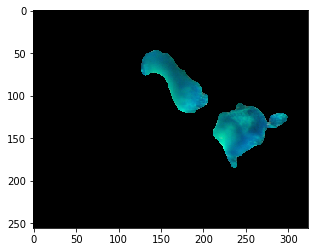

In [25]:
blue_rel_orig[0].Show()

In [26]:
# Unifirmormity of whole embryos
unif = [np.unique(x,return_counts=True) for x in embryos_orig_rel]
unif_orig = []
for x in embryos_orig_rel:
    val, counts = np.unique(x,return_counts=True)
    if val[0] == 0:
        val = val[1:]
        counts = counts[1:]
    unif_orig.append([val,counts])
    
unif_orig = np.array([np.sum(counts**2) for _,counts in unif_orig])
print(unif_orig.max(), unif_orig.min())
max_unif = unif_orig.max()
min_unif = unif_orig.min()
unif_norm_orig = [(((x - min_unif) / (max_unif - min_unif))) for x in unif_orig]

94135159 3666306


In [27]:
# Unifirmormity of blue area
unif_blue = [np.unique(x,return_counts=True) for x in blue_rel_orig]
unif_blue_res = []
for x in unif_blue:
    val, counts = np.unique(x,return_counts=True)
    if val[0] == 0:
        val = val[1:]
        counts = counts[1:]
    unif_blue_res.append([val,counts])

unif_blue_res = np.array([np.sum(counts**2) for _,counts in unif_blue_res])
max_unif = unif_blue_res.max()
min_unif = unif_blue_res.min()
print(max_unif, min_unif)
unif_norm_blue = [(((x - min_unif) / (max_unif - min_unif))) for x in unif_blue_res]

5219 391


In [28]:
d = {'unif_embryo': unif_norm_orig,
    'unif_blue': unif_norm_blue,
    'std_embryo': stand_dev,
    'std_blue': tot_std_blue}
df_text = pd.DataFrame(d)
df_text = df_text.join(df[['class_kmeans', 'thresh_class','thresh_class_2']])
df_text.head(3)

,unif_embryo,unif_blue,std_embryo,std_blue,class_kmeans,thresh_class,thresh_class_2
0,0.162819,0.112676,86.804483,68.000097,1,1,1
1,0.224477,0.129246,77.071195,40.822313,1,1,1
2,0.077025,0.207539,69.277888,51.765870,0,0,0


In [29]:
# create data
X = df_text.drop(columns=['class_kmeans', 'thresh_class','thresh_class_2'])
y = df_text[['class_kmeans', 'thresh_class','thresh_class_2']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

# define and train kmeans svc
clf = svm.SVC()
clf.fit(X_train,y_train['class_kmeans'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['class_kmeans'], pred, zero_division=0))

# define and train thresh svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class'], pred, zero_division=0))

# define and train thresh 2 svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class_2'])
# predict on unseen data
pred =clf.predict(X_test)
# predict on train and concat
print(classification_report(y_test['thresh_class_2'], pred, zero_division=0))
#predict_on_train
pred_train = clf.predict(X_train)
predictions = np.hstack((pred,pred_train))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.20      0.50      0.29         4
           2       0.00      0.00      0.00         3

    accuracy                           0.17        12
   macro avg       0.07      0.17      0.10        12
weighted avg       0.07      0.17      0.10        12

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3

    accuracy                           0.33        12
   macro avg       0.11      0.33      0.17        12
weighted avg       0.11      0.33      0.17        12

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.20      0.50      0.29         4
           2       0.00      0.00      0.00         2

    accuracy        

[0 1]
(58,) (58, 2)


/tmp/ipykernel_34717/573906839.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['preds'] = predictions


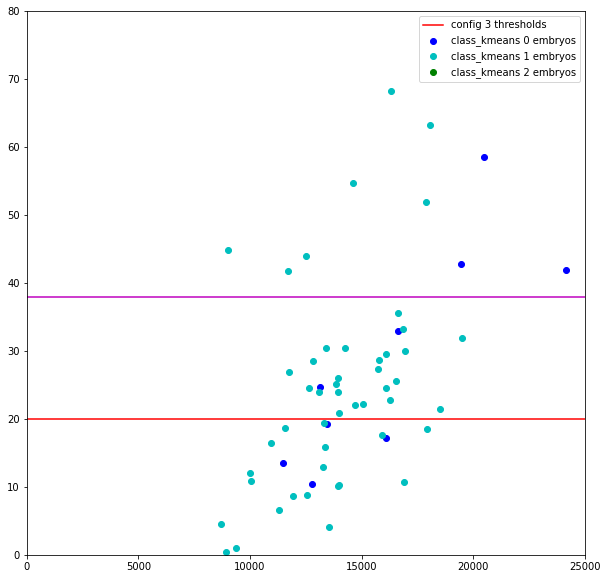

In [30]:
plt.figure(figsize=(10,10))
x_rg = np.arange(2)

# threshold 3
y_3 = np.full(shape=(1000), fill_value=20)
x_3 = np.linspace(0,25000,1000)
plt.plot(x_3,y_3, label="config 3 thresholds", color='r')
y_3 = np.full(shape=(1000), fill_value=38)
x_3 = np.linspace(0,25000,1000)
plt.plot(x_3,y_3, color='m')
plt.margins(x=0,y=0)

colors = ['b', 'c', 'g']

plot_df = df[['area','percentage area blue']]
print(np.unique(predictions))
print(predictions.shape, plot_df.shape)
plot_df['preds'] = predictions
for i in range(3):
    plt.scatter(x=plot_df[plot_df['preds'] == i]['area'], 
                y=plot_df[plot_df['preds'] == i]['percentage area blue'], 
                c=colors[i], label=f"class_kmeans {i} embryos")
plt.ylim([0,80])
plt.legend()
plt.show()

<h4>Combined</h4>

In [31]:
df_text.head(2)

,unif_embryo,unif_blue,std_embryo,std_blue,class_kmeans,thresh_class,thresh_class_2
0,0.162819,0.112676,86.804483,68.000097,1,1,1
1,0.224477,0.129246,77.071195,40.822313,1,1,1


In [32]:
df.head(2)

,area,perimeter,area blue,perimeter blue,percentage area blue,percentage perim blue,class_kmeans,thresh_class,thresh_class_2
0,14687.0,854.54,3231.0,274.01,22.00,32.07,1,1,1
1,16872.0,758.26,5604.0,325.70,33.21,42.95,1,1,1


In [33]:
comb = df.drop(columns=['class_kmeans', 'thresh_class', 'thresh_class_2'])
comb = comb.join(df_text.drop(columns=['class_kmeans', 'thresh_class', 'thresh_class_2']))
comb['circ'] = circularity
comb['round'] = roundness
comb['round_blue'] = tot_round_blue

comb.head(2)

,area,perimeter,area blue,perimeter blue,percentage area blue,percentage perim blue,unif_embryo,unif_blue,std_embryo,std_blue,circ,round,round_blue
0,14687.0,854.54,3231.0,274.01,22.00,32.07,0.162819,0.112676,86.804483,68.000097,0.461589,0.252744,0.540781
1,16872.0,758.26,5604.0,325.70,33.21,42.95,0.224477,0.129246,77.071195,40.822313,0.352192,0.368759,0.675828


In [34]:
comb_arr = comb.to_numpy()
comb_arr = np.hstack((comb_arr,blue_feat))

In [35]:
comb_arr.shape

(58, 92353)

In [36]:
# create data
X = comb_arr
y = df[['class_kmeans', 'thresh_class','thresh_class_2']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# define and train kmeans svc
clf = svm.SVC()
clf.fit(X_train,y_train['class_kmeans'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['class_kmeans'], pred, zero_division=0))

# define and train thresh svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class'])
# predict on unseen data
pred =clf.predict(X_test)
print(classification_report(y_test['thresh_class'], pred, zero_division=0))

# define and train thresh 2 svc
clf = svm.SVC()
clf.fit(X_train,y_train['thresh_class_2'])
# predict on unseen data
pred =clf.predict(X_test)
# predict on train and concat
print(classification_report(y_test['thresh_class_2'], pred, zero_division=0))
#predict_on_train
pred_train = clf.predict(X_train)
predictions = np.hstack((pred,pred_train))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         1

    accuracy                           0.92        12
   macro avg       0.92      0.96      0.93        12
weighted avg       0.94      0.92      0.92        12

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.14      1.00      0.25         1
           2       0.00      0.00      0.00         1

    accuracy                           0.50        12
   macro avg       0.38      0.50      0.31        12
weighted avg       0.85      0.50      0.58        12

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      1.00      0.67         3
           2       0.00      0.00      0.00         3

    accuracy        

<h4>Histograms of features</h4>

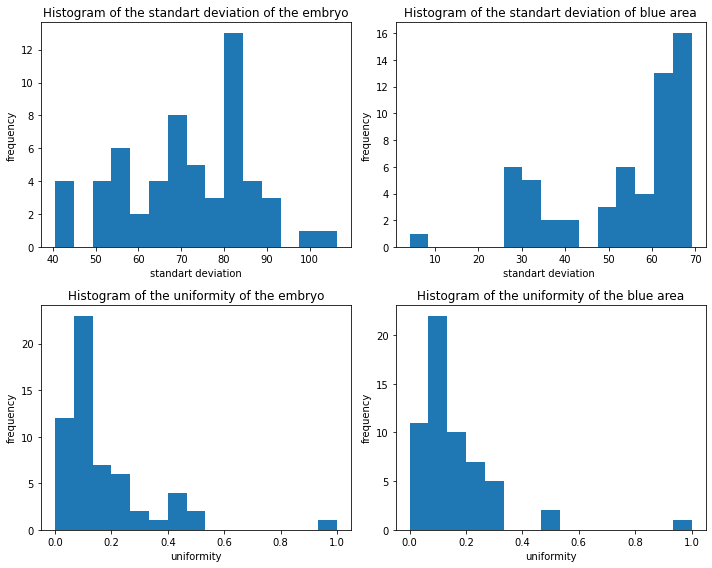

In [37]:

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax[0,0].hist(stand_dev, bins=15)
ax[0,0].set_xlabel("standart deviation")
ax[0,0].set_ylabel("frequency")
ax[0,0].set_title("Histogram of the standart deviation of the embryo")

ax[0,1].hist(tot_std_blue, bins=15)
ax[0,1].set_xlabel("standart deviation ")
ax[0,1].set_ylabel("frequency")
ax[0,1].set_title("Histogram of the standart deviation of blue area")

ax[1,0].hist(unif_norm_orig, bins=15)
ax[1,0].set_xlabel("uniformity")
ax[1,0].set_ylabel("frequency")
ax[1,0].set_title("Histogram of the uniformity of the embryo")

ax[1,1].hist(unif_norm_blue, bins=15)
ax[1,1].set_xlabel("uniformity")
ax[1,1].set_ylabel("frequency")
ax[1,1].set_title("Histogram of the uniformity of the blue area")
plt.tight_layout()

In [39]:
df.drop(columns=['class_kmeans', 'thresh_class', 'thresh_class_2']).to_csv("stats_area")

In [41]:
df_text.drop(columns=['class_kmeans', 'thresh_class', 'thresh_class_2']).to_csv("stats_unif")